# PS reconstruction, Gaussian beam

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_awa_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus
from bmadx.plot import plot_projections
from bmadx.constants import PI



## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
save_dir = os.path.join('data', 'gaussian_beam', 'low_E_spread')
p0c = 43.36e6 # reference momentum in eV/c

gt_beam = torch.load("data/gaussian_beam.pt")

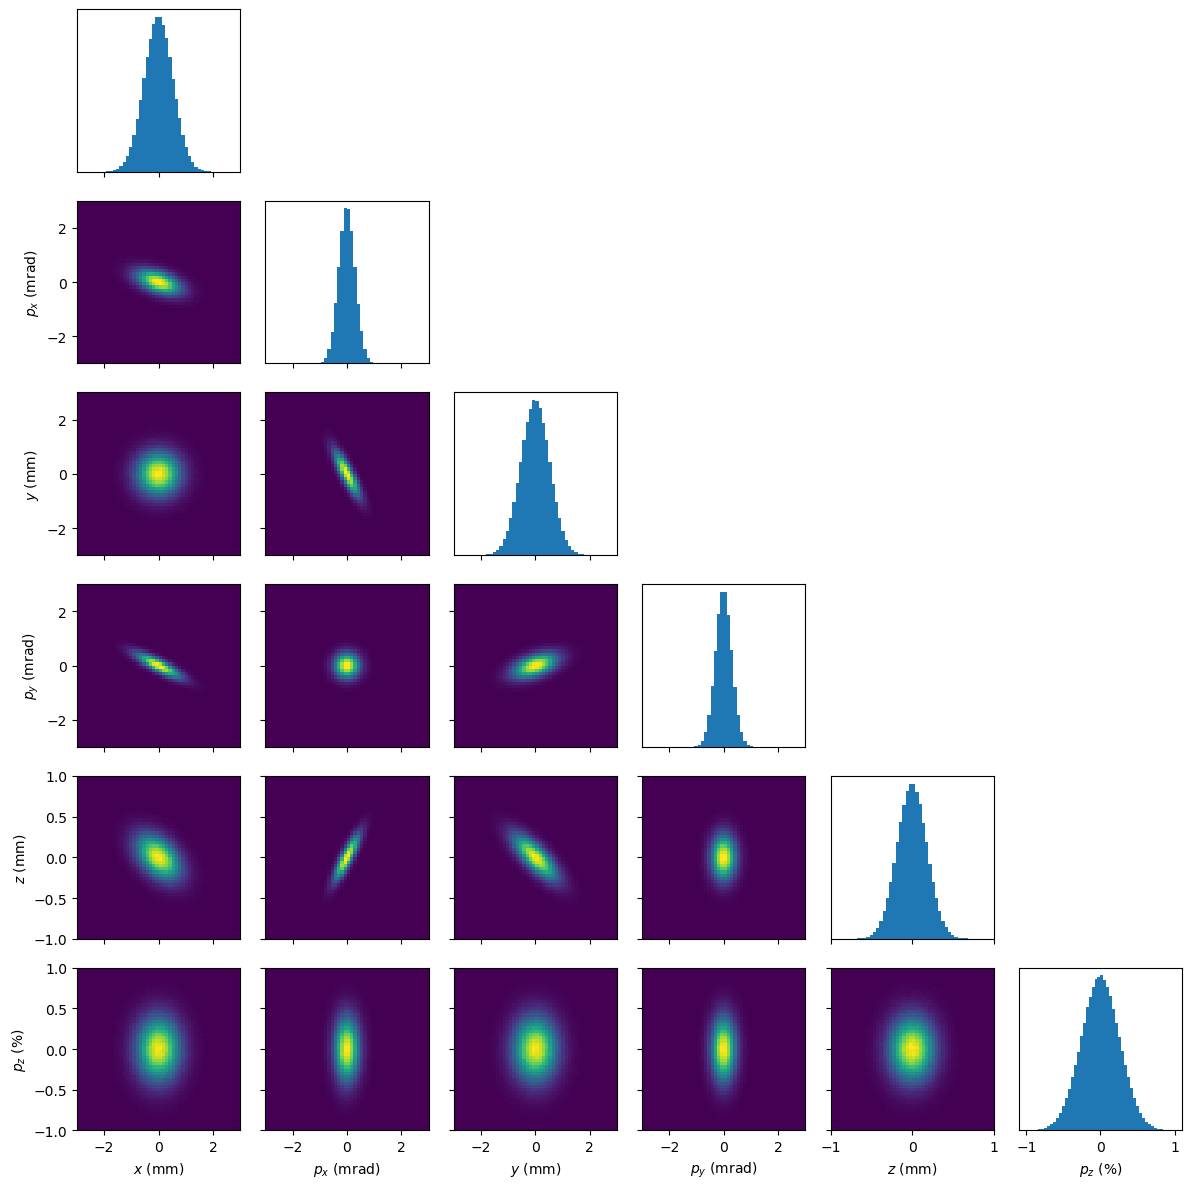

In [3]:
#plot gt beam
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-5e-3, 5e-3],
                 [-5e-2, 5e-2]]) *0.2
fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims = lims,
    background = 0
)
plt.show()

In [4]:
gt_beam.pz.std()

tensor(0.0026)

In [5]:
gt_beam.z.std()

tensor(0.0002)

## Define diagnostics lattice parameters

In [12]:
# triplet params obtained from triplet-opt.ipynb
#k1 =            -39.160589
#k2 =             25.787117
#k3 =            -25.667133

k1 =            -24.868402
k2 =             26.179029
k3 =            -26.782126

In [13]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-3, 3, n_ks) # quad ks
vs = torch.tensor([0, 3e6]) # TDC off/on
gs = torch.tensor([-2.22e-16, -20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
#print(train_params.shape)
#print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-5, 5, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

## Complete 3D scan training data

In [14]:
# generate and save train and test datasets
train_dset_3d_scan = run_awa_3d_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join(save_dir, '3d_scan_train.dset')
    )

print(train_dset_3d_scan.params.shape)
print(train_dset_3d_scan.images.shape)

dataset saved as 'data/gaussian_beam/low_E_spread/3d_scan_train.dset'
torch.Size([20, 3, 1])
torch.Size([20, 1, 200, 200])


torch.Size([200, 200])


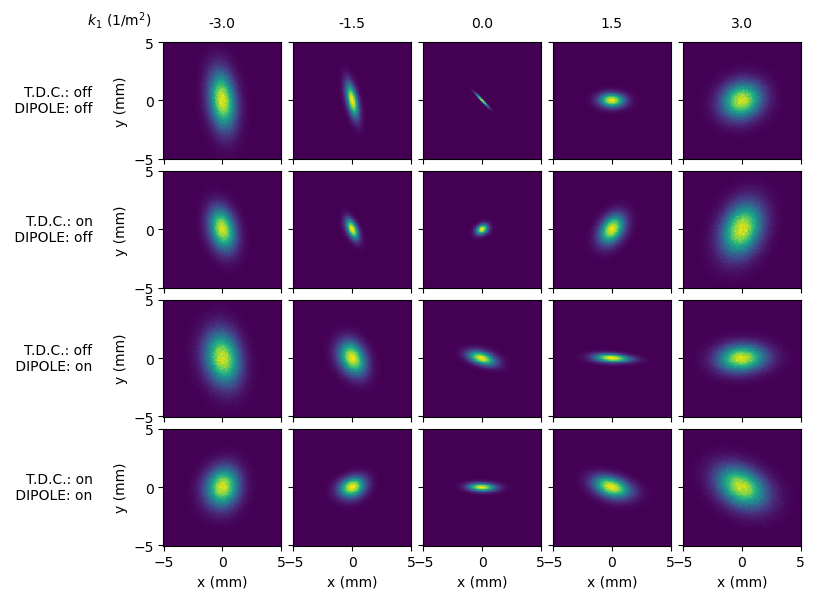

In [15]:
from phase_space_reconstruction.visualization import plot_3d_scan_data
fig, ax = plot_3d_scan_data(train_dset_3d_scan, bins, publication_size=True)
#for ele in ax[-1]:
#    ele.set_xticks([-20,0,20])
#for ele in ax[:,0]:
#    ele.set_yticks([-20,0,20])

#fig.savefig("gaussian_data.png",dpi=300)
#fig.savefig("gaussian_data.svg")
plt.show()

In [20]:
%%time

# training with 4 gpus
pred_beam_3d_scan_10_000, model = train_3d_scan(
    train_dset_3d_scan, 
    lattice, 
    p0c, 
    screen, 
    ids = scan_ids,
    n_epochs = 3_000, 
    n_particles = 100_000, 
    device = 'cuda:0',
    save_dir = save_dir,
    distribution_dump_frequency=500,
    distribution_dump_n_particles=1_000_000,
    lr=0.001,
    )

Using device: cuda:0
0 tensor(4.7582e-05, device='cuda:0', grad_fn=<MeanBackward0>)
100 tensor(6.3029e-06, device='cuda:0', grad_fn=<MeanBackward0>)
200 tensor(3.6119e-06, device='cuda:0', grad_fn=<MeanBackward0>)
300 tensor(3.2552e-06, device='cuda:0', grad_fn=<MeanBackward0>)
400 tensor(3.2862e-06, device='cuda:0', grad_fn=<MeanBackward0>)
500 tensor(3.0201e-06, device='cuda:0', grad_fn=<MeanBackward0>)
600 tensor(3.1567e-06, device='cuda:0', grad_fn=<MeanBackward0>)
700 tensor(2.7954e-06, device='cuda:0', grad_fn=<MeanBackward0>)
800 tensor(2.6984e-06, device='cuda:0', grad_fn=<MeanBackward0>)
900 tensor(2.5319e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1000 tensor(2.4298e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1100 tensor(2.7243e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1200 tensor(2.7482e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1300 tensor(2.6448e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1400 tensor(2.5411e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1

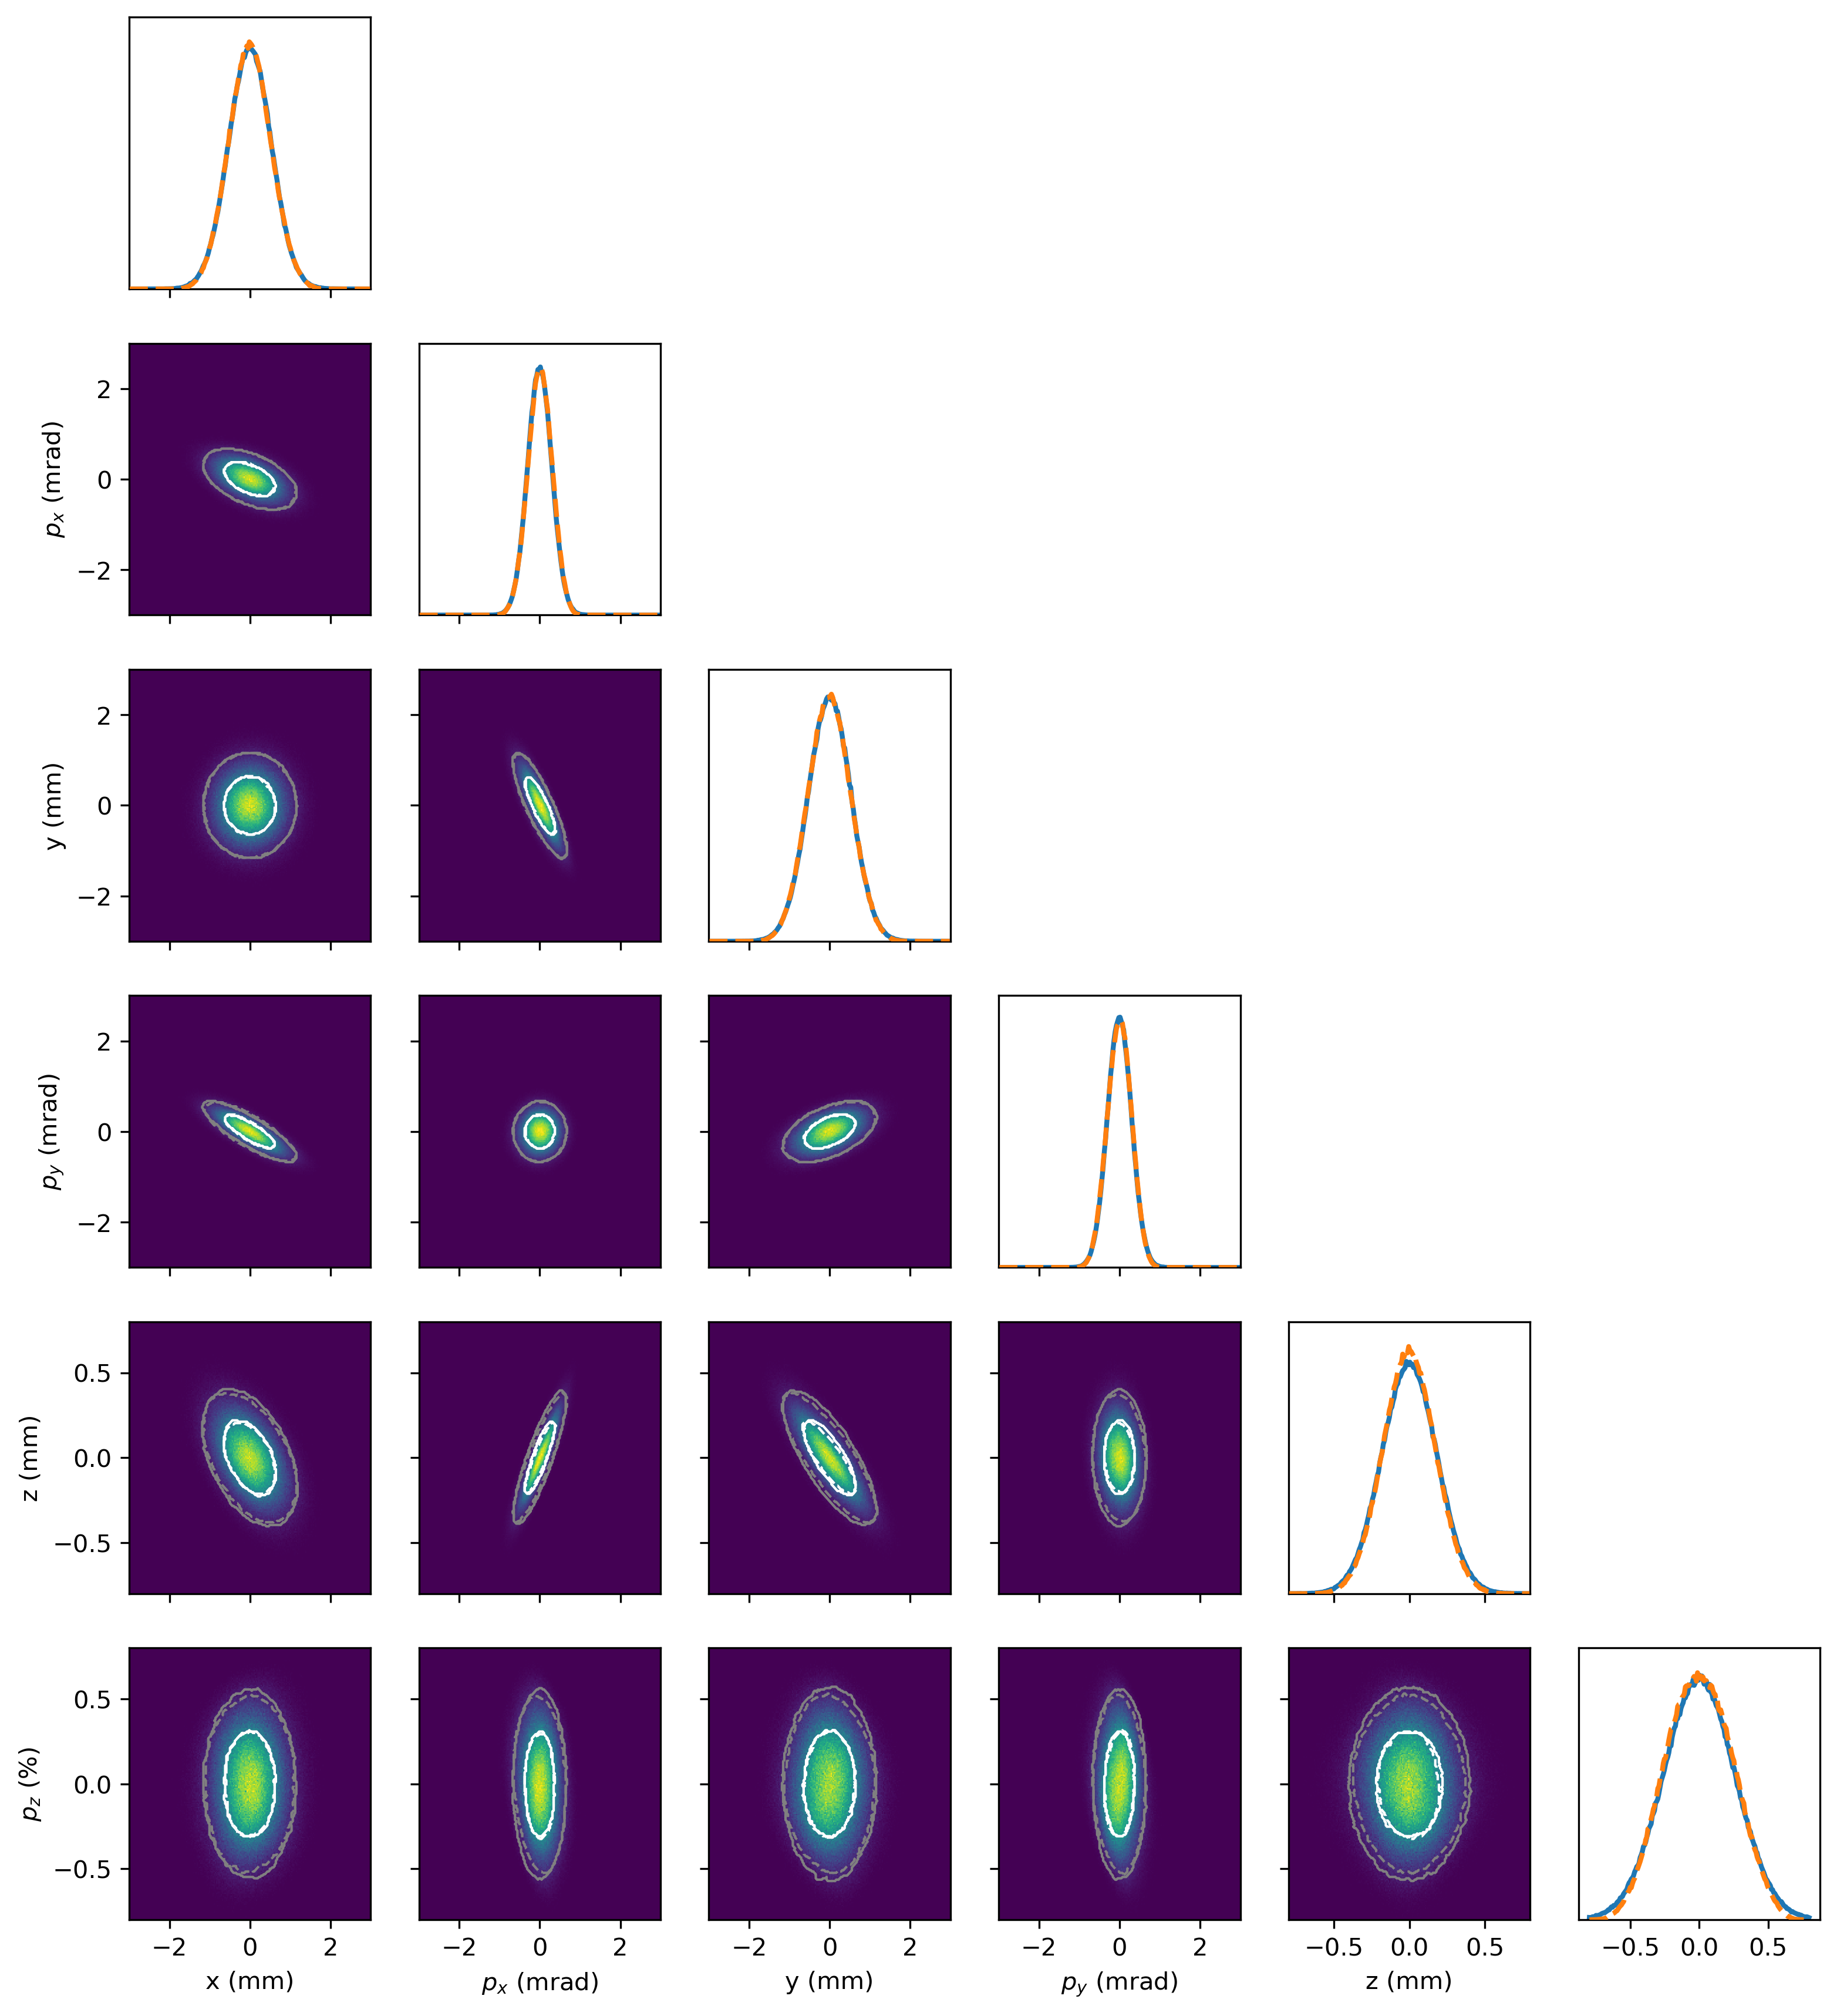

In [26]:
import torch
from stats import plot_projections_with_contours, show_cov_stats
import os

lims = np.array([[-15, 15],
                 [-15, 15],
                 [-15, 15],
                 [-15, 15],
                 [-4, 4],
                 [-4, 4]])*0.2 

recn_dist = torch.load(os.path.join(save_dir, 'dist_3000.pt'))
recn_dist.data = recn_dist.data
fig,ax = plot_projections_with_contours(
    recn_dist,
    gt_beam,
    n_bins=200,
    contour_percentiles = [50, 90],
    custom_lims=lims,
    contour_smoothing=0.25,
)

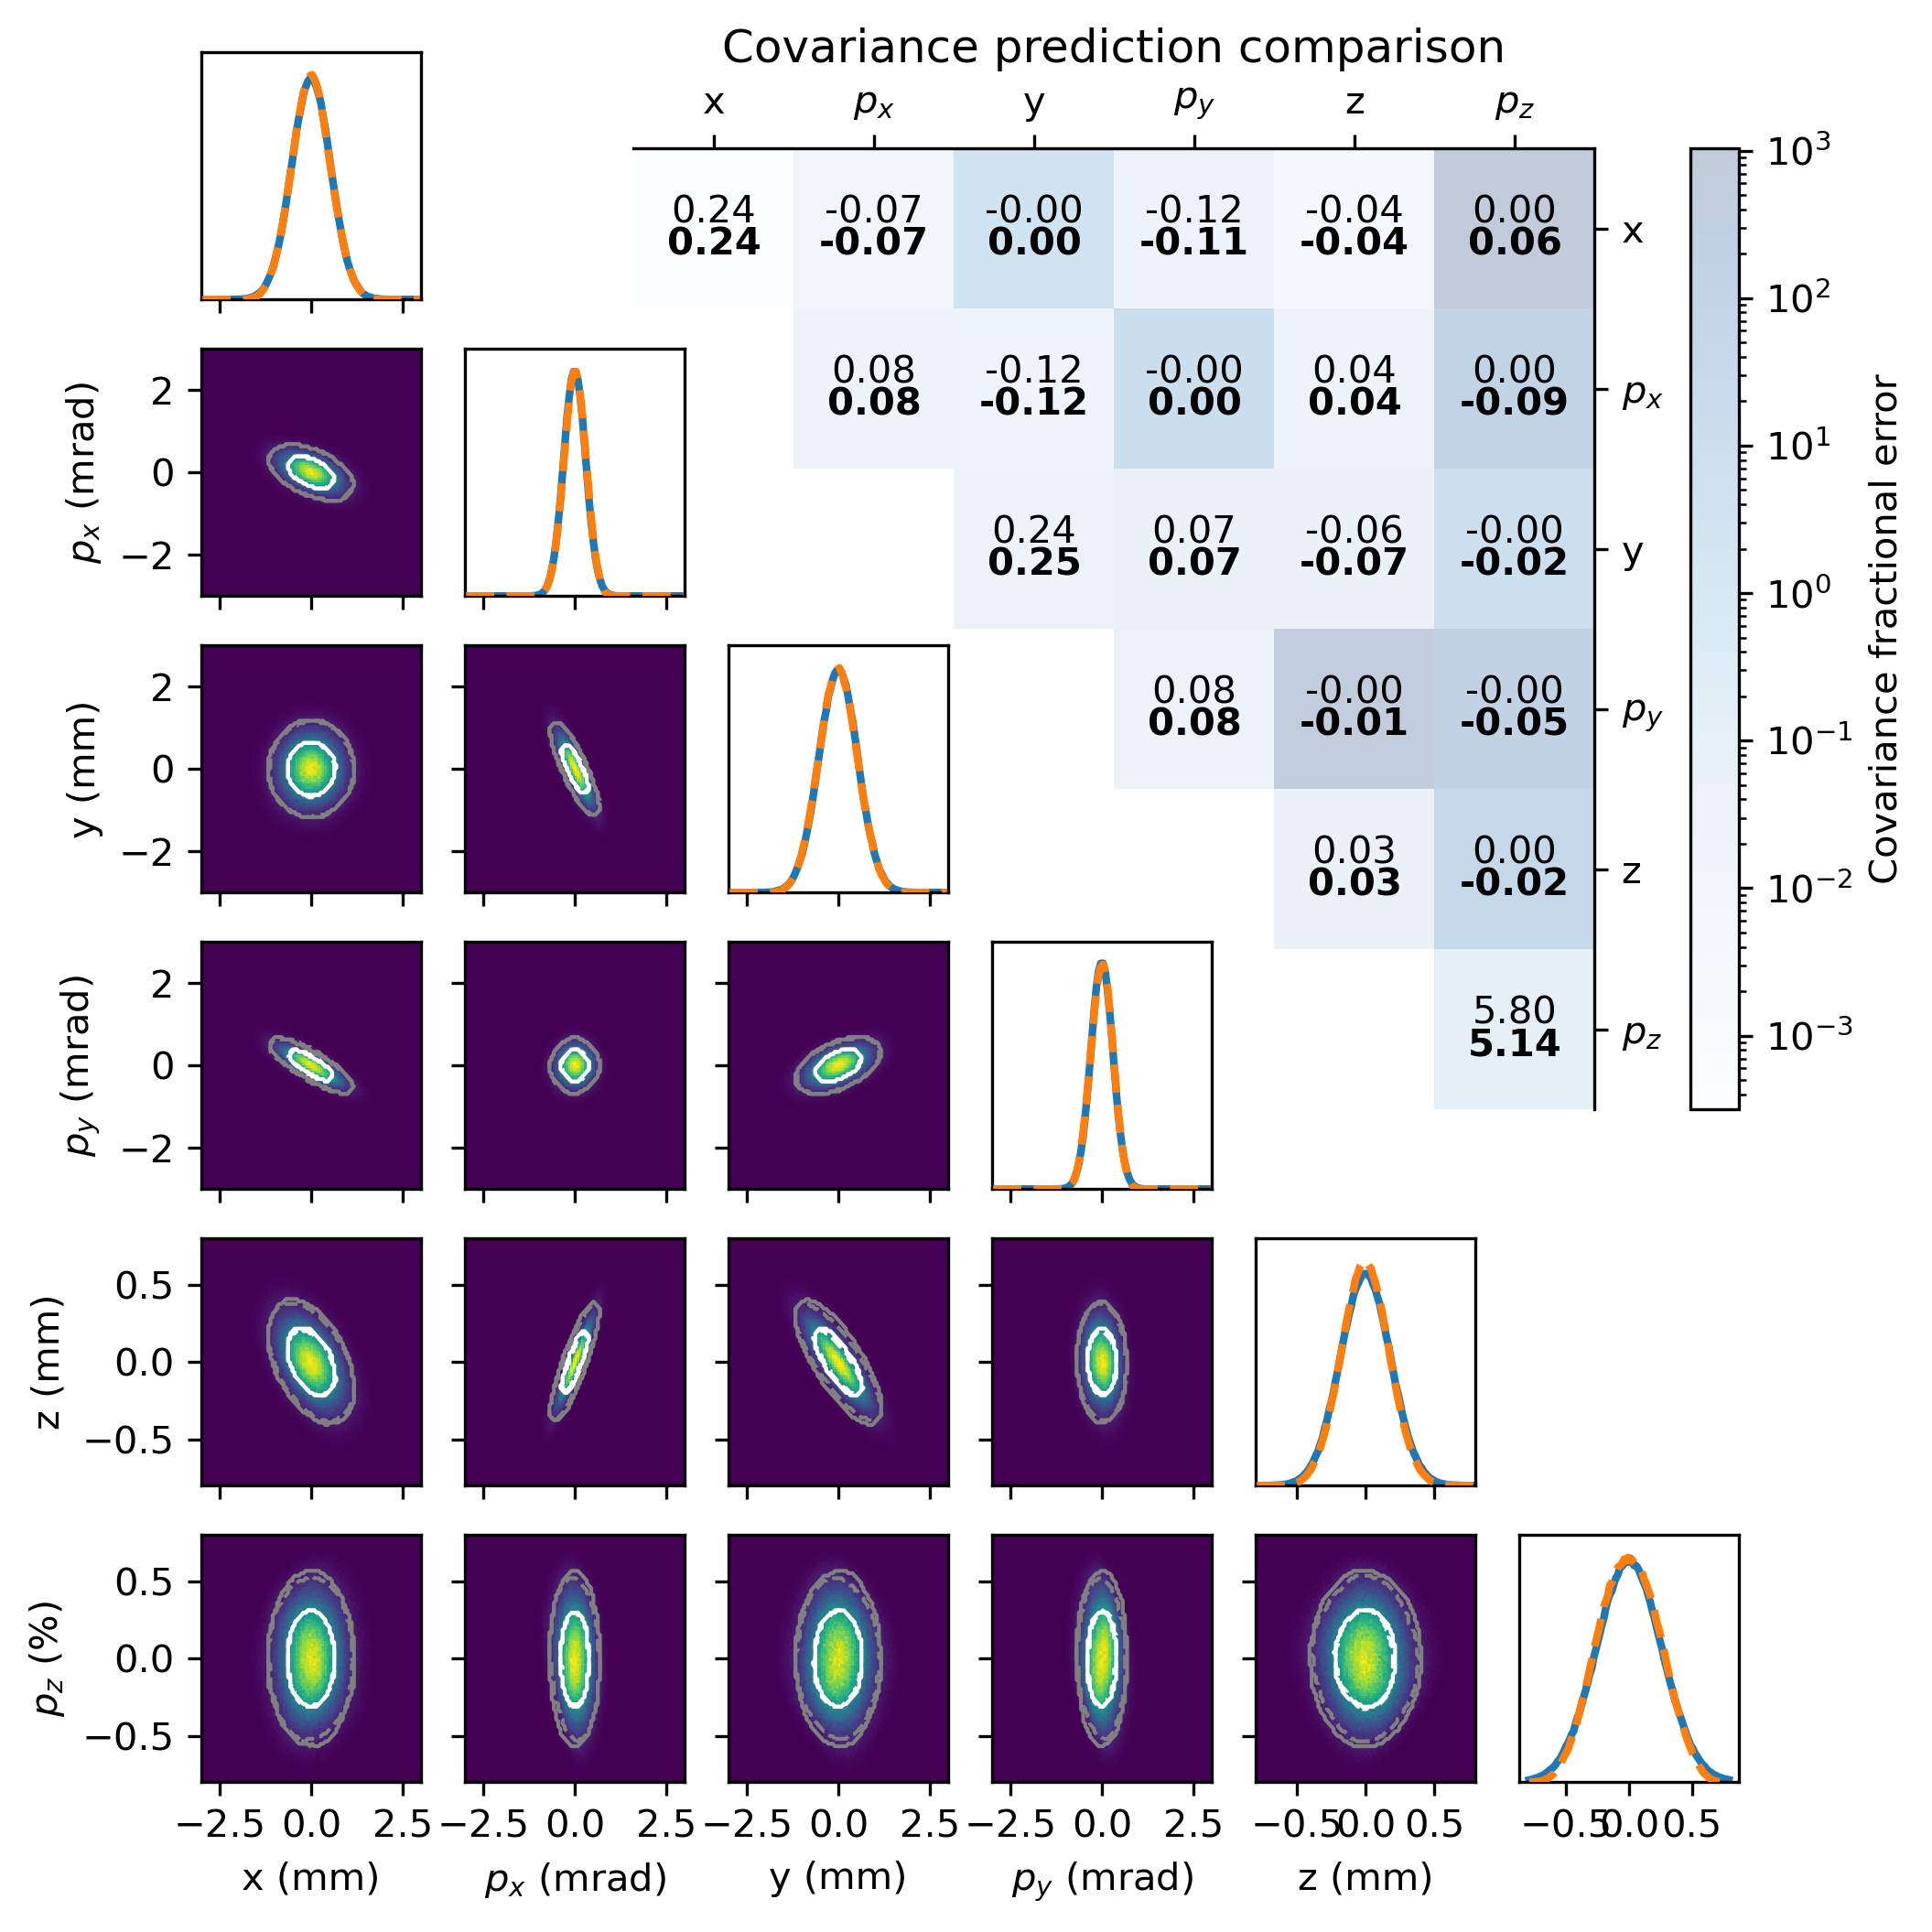

In [27]:
from stats import plot_prab_figure

fig = plot_prab_figure(
    recn_dist,
    gt_beam,
    n_bins=100,
    contour_percentiles = [50, 90],
    custom_lims=lims,
)
#fig.savefig("gaussian_reconstruction.png",dpi=300)
#fig.savefig("gaussian_reconstruction.svg")

In [ ]:
torch.cuda.empty_cache()